In [1]:
import os
import sys
os.environ["THEANO_FLAGS"] = "device=gpu"
sys.path.append(os.getcwd()+"/..")
from tasks import check

Using gpu device 0: Tesla K20Xm (CNMeM is disabled, CuDNN 3007)
/home/mcherti/build/Theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Couldn't import dot_parser, loading of dot files will not be possible.


/home/mcherti/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


In [2]:
from model import model53, model54

In [50]:
all_layers = model54(nb_filters=512, w=32, h=32, c=3)

In [39]:
import theano.tensor as T
import theano
from lasagne import layers

X_scale1 = T.tensor4()
X_scale2 = T.tensor4()
X_scale3 = T.tensor4()
X_scale4 = T.tensor4()

X_scale1_out = T.tensor4()
X_scale2_out = T.tensor4()
X_scale3_out = T.tensor4()
X_scale4_out = T.tensor4()


input_tensors = [X_scale4]
output_tensors = [X_scale1]

input_layers = ["input"]
output_layers = ["output"]

inputs = {all_layers[l]: t for t, l in zip(input_tensors, input_layers)}
outputs = map(lambda name:all_layers[name], output_layers)

output_pred_tensors = layers.get_output(outputs, inputs)
lambdas = [1]
loss = 0
for outp, outp_pred, lambda_ in zip(output_tensors, output_pred_tensors, lambdas):
    loss += ((outp_pred - outp) ** 2).mean() * lambda_

In [40]:
from lasagne import updates
import numpy as np
params = layers.get_all_params(all_layers.values(), trainable=True)
print("Number of params : {}".format(layers.count_params(all_layers.values(), trainable=True))) 
lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
params_updates = updates.adam(loss, params, learning_rate=lr)

Number of params : 535043


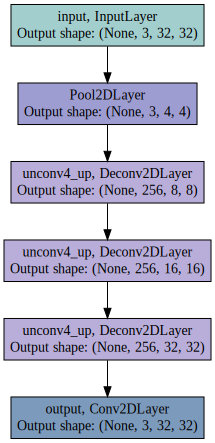

In [41]:
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG
draw_to_file(layers.get_all_layers(all_layers['output']), 'out.svg')
SVG('out.svg')

In [42]:
train_fn = theano.function(input_tensors + output_tensors, loss, updates=params_updates, on_unused_input='warn')

In [43]:
predict_fn = theano.function(input_tensors, output_pred_tensors, on_unused_input='warn')

In [ ]:
from data import load_data
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.easy import iterate_minibatches
from lasagnekit.datasets.imagecollection import ImageCollection
from lasagnekit.datasets.transformed import Transformed
w, h = 32, 32
scale = {1: 32, 2: 16, 3: 8, 4: 4}
batch_size = 128

c = 3
folder = "{}/icons".format(os.getenv("DATA_PATH"))
data_scale1 = ImageCollection(size=(w, h), nb=1535, mode='all', folder=folder)

def preprocess(x, s=32):
    x = x.reshape((x.shape[0], s, s, c))
    x = x.transpose((0, 3, 1, 2))
    return x
data_scale1.load()

In [14]:
print(all_layers['output'].output_shape)

(None, 3, 32, 32)


In [34]:
lr.set_value(0.01)
loss_list = []
for i in range(10000):
        
    X_scale1 = preprocess(data_scale1.X, s=scale[1])

    total_loss = 0.
    for mini_batch in iterate_minibatches(len(data_scale1.X), batch_size):
        loss_val = train_fn(X_scale1[mini_batch], X_scale1[mini_batch])
        total_loss += loss_val
    print(total_loss)
    loss_list.append(total_loss)
plt.plot(loss_list)

0.725803632289
0.718104656786
0.715140406042
0.708850108087
0.709208399057
0.709639601409
0.70945116505
0.70724343881
0.70666828379
0.70649753511
0.705459032208
0.705639488995
0.704604506493
0.710451602936
0.722196083516
0.719306312501
0.74153766036
0.729415569454
0.717234957963
0.714741170406
0.709644321352
0.709467828274
0.715073619038
0.740628026426
0.736898928881
0.728763278574
0.72187917307
0.716456532478
0.716092288494
0.711882393807
0.710469741374
0.712847936898
0.723935127258
0.722406409681
0.732359483838
0.722891587764
0.715583264828
0.713104266673
0.719489954412
0.714329101145
0.711730610579
0.711057651788
0.707792617381
0.706938505173
0.706846147776
0.707616310567
0.707519244403
0.708521712571
0.715615488589
0.738294173032
0.737646900117
0.738524831831
0.723826237023
0.716812755913
0.712995178998
0.713438265026
0.714637961239
0.713395599276
0.71099941805
0.720685634762
0.722663871944
0.710298903286
0.714199353009
0.710385963321
0.713900569826
0.709086935967
0.723452653736
0.

KeyboardInterrupt: 

In [47]:
out1, = predict_fn(X_scale1)

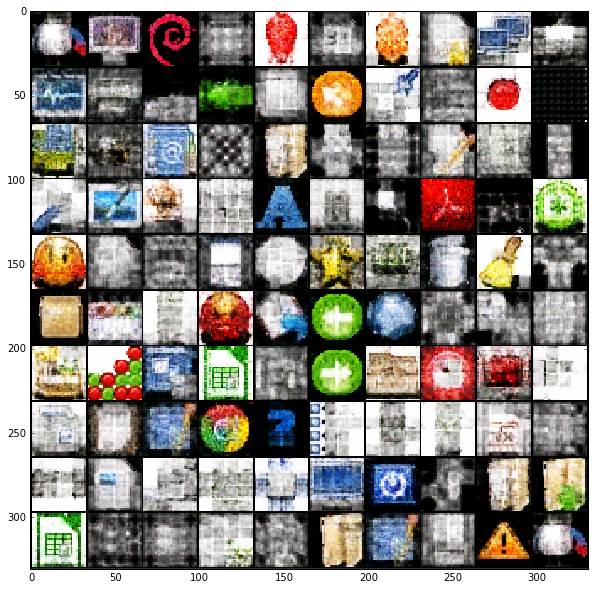

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import dispims_color
fig = plt.figure(figsize=(10, 10))
img = dispims_color(out1[0:100].transpose((0, 2, 3, 1)),border=1)
plt.imshow(img, interpolation='none')

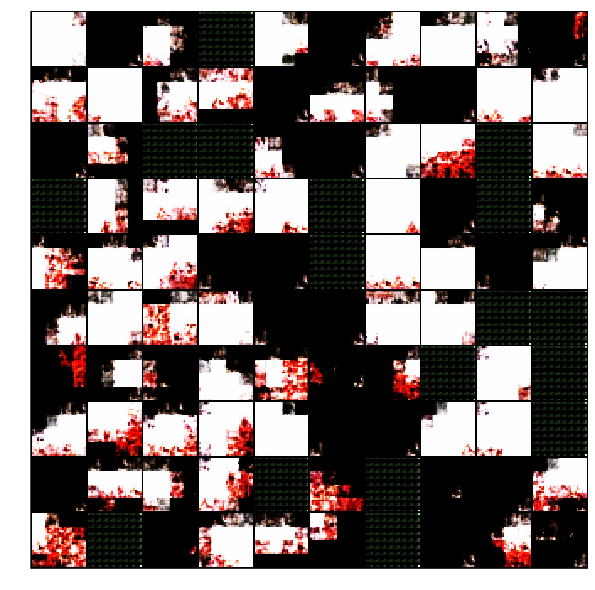

In [49]:
ss = np.random.uniform(size=(100, c, 32, 32))
ss = ss.astype(np.float32)
for i in range(100):
    ss, = predict_fn(ss)
    
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import dispims_color
fig = plt.figure(figsize=(10, 10))
img = dispims_color(ss[0:100].transpose((0, 2, 3, 1)),border=1)
plt.axis('off')
plt.imshow(img, interpolation='none')